In [1]:
import math
from random import randint, choice
from gym.envs.classic_control import CartPoleEnv
import tensorflow as tf
import pandas as pd
import numpy as np
import heapq
from random import random, sample
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

In [57]:
batch_size = 256
T = batch_size*100
GAMMA = 0.99
reward_decay = 0.9
learning_rate = 0.001
update_target_network_time = 1000

In [3]:
class Transaction:
    columns = ['state', 'action', 'reward', 'next_state', 'done', 'label']
    actions = [[0, 1], [1, 0]]
    def __init__(self, item):
        self.item = dict(zip(Transaction.columns, item))
        
    def  __lt__(self, other):
        #sort by time
        return self.item['id'] < other.item['id']
        #sort by gained label
        #return self.item['label'] < other.item['label']
    
    def __repr__(self):
        return str(self.item)
    
    def get_next_state_and_(self):
        return self.item['state'] + Transaction.actions[self.item['action']]
    
    def __getitem__(self, key):
        return self.item[key]
    
    def __setitem__(self, key, value):
        self.item[key] = value

class Memory:
    def __init__(self, max_size):
        MAX_TRANSACTION = Transaction(Transaction.columns)
        MAX_TRANSACTION.item['id'] = -1
        self.d = []
        self.id = 0
        self.max_size = max_size
        
    def insert(self, item):
        self.id += 1
        item['id'] = self.id
        #print(self.d)

        if len(self.d) == self.max_size:
            heapq.heapreplace(self.d, item)
        else:
            heapq.heappush(self.d, item)

    def batch(self, n):
        if len(self.d) > n:
            batch = np.array(sample(self.d, n))
            return batch
        else:
            return np.array(self.d)

def get_labels(batch):
    return np.array([transaction['label'] for transaction in batch])

def test():
    D = Memory(2)
    item1 = Transaction([np.array([0,1,2,3]), 1,0,np.array([3,2,1,0]),0,10])
    item2 = Transaction([np.array([0,1,2,3]), 1,0,np.array([3,2,1,0]),0,10])
    item3 = Transaction([np.array([0,1,2,3]), 1,0,np.array([3,2,1,0]),0,10])

    D.insert(item1)
    D.insert(item2)
    D.insert(item3)

    print(D.d, D.batch(2), D.d)
    item = Transaction([np.array([-1,1,2,3]), 1,0,np.array([3,2,1,0]),0,10])
    D.insert(item)
    print(D.d, D.batch(1))

In [48]:
class QNetwork:
    def __init__(self):
        self.state_size = 4
        self.action_size = 2
        self.units = 32
        self.n_layers = 4
        self.model_folder = './model/'
        
        self.input = tf.placeholder(shape=(None, self.state_size), dtype=tf.float32)
        self.label = tf.placeholder(shape=(None, self.action_size), dtype=tf.float32)
        self.global_step = tf.Variable(0, dtype=tf.int32)
        
        self.build_network()
        self.sess = sess = tf.Session(config=tf.ConfigProto(device_count={'GPU': 1}))
        self.target_Q_sess = sess = tf.Session(config=tf.ConfigProto(device_count={'GPU': 1}))
        
        self.sess.run(tf.global_variables_initializer())
        self.target_Q_sess.run(tf.global_variables_initializer())
        
        self.saver = tf.train.Saver()

    def build_network(self):
        layers = [0]*self.n_layers
        layers[0] = tf.layers.dense(inputs=self.input, units=self.units, activation=tf.nn.relu, name='layer_0')
        for i in range(self.n_layers-1):
            layers[i+1] = tf.layers.dense(inputs=layers[i], units=self.units, activation=tf.nn.relu, name='layer_%d'%(i+1))
        
        self.qvalue = tf.layers.dense(inputs=layers[-1], units=self.action_size)
        self.best_qvalue = tf.reduce_max(self.qvalue, axis=1)

        self.loss = tf.losses.mean_squared_error(labels=self.label, predictions=self.qvalue)
        optimizer = tf.train.AdamOptimizer(learning_rate)
        self.train_step = self.do_clipping(self.loss, optimizer)
        #self.train_step = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)
        self.best_action = tf.argmax(self.qvalue, axis=1)
        
    def do_clipping(self, loss, optimizer):
        grad_vars = optimizer.compute_gradients(loss)
        self.grad_vars = [
          (tf.clip_by_norm(grad, clip_norm=10), var)
          for grad, var in grad_vars if grad is not None
        ]
        self.grad_dict = dict([
          [var.name, grad]
          for grad, var in self.grad_vars
        ])

        train_step = optimizer.apply_gradients(self.grad_vars, global_step=self.global_step)
        return train_step

    def get_Q_value(self, states, sess='target'):
        sess = self.decide_sess(sess)
        return sess.run(self.qvalue, feed_dict={self.input: states})
    
    def get_best_Q_value(self, states, sess='target'):
        sess = self.decide_sess(sess)
        return sess.run(self.best_qvalue, feed_dict={self.input: states})
    
    def get_best_action(self, state, sess='target'):
        sess = self.decide_sess(sess)
        return sess.run(self.best_action, feed_dict={self.input: [state]})[0]
            
    def update(self, batch):
        states = get_states(batch)
        labels = get_labels(batch)
        
        return self.sess.run([self.train_step, self.loss], feed_dict={self.input: states, self.label: labels})
    
    def reload_target_Q_network(self):
        self.saver.restore(self.target_Q_sess, tf.train.latest_checkpoint(self.model_folder))
        
    def save(self, name):
        self.saver.save(self.sess, '%s/%s'%(self.model_folder, name), global_step=self.global_step)
        
    def decide_sess(self, sess):
        if sess == 'target':
            sess = self.target_Q_sess
        elif sess == 'online':
            sess = self.sess
        else:
            raise Exception('unknown sess %s'%(sess))
        return sess
        

In [73]:
def transform_to_Q_input(states, actions):
    action_onehots = [Transaction.actions[action] for action in actions]
    Q_inputs = np.array([state + action_onehot for state, action_onehot in zip(states, action_onehots)])
    return Q_inputs

def get_next_states(batch):
    next_states = [transaction['next_state'] for transaction in batch]
    return next_states

def get_states(batch):
    states = [transaction['state'] for transaction in batch]
    return states

def get_labels(batch):
    labels = [transaction['label'] for transaction in batch]
    return labels

def get_actions(batch):
    actions = [transaction['action'] for transaction in batch]
    return actions

def add_label(one_round, Q, gamma):
    states = get_states(one_round)
    states_qvalues = Q.get_Q_value(states, 'target') #batch_size,action_size
    
    next_states = get_next_states(one_round)
    next_states_best_qvalues = Q.get_best_Q_value(next_states) #batch_size,1
    
    for transaction, state_qvalue, next_state_best_qvalue in zip(one_round, states_qvalues, next_states_best_qvalues):
        if transaction['done']:
            reward = transaction['reward']
        else:
            reward = transaction['reward'] + GAMMA*next_state_best_qvalue
            
        label = state_qvalue
        label[transaction['action']] = reward
        
        transaction['label'] = label

In [71]:
def plot(series, range_size):
    series = [np.mean(series[i:i+range_size]) for i in range(0, len(series), range_size)]
    plt.plot(series, 'y')
    display.display(plt.gcf())
    display.clear_output(wait=True)

KeyboardInterrupt: 

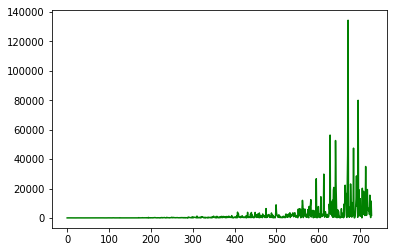

In [74]:
tf.reset_default_graph()

D = Memory(T)
Q = QNetwork()

env = CartPoleEnv()
#env.theta_threshold_radians = 2 * math.pi * 1/4
state = env.reset()
state = state.tolist()

metrics  = {}
metrics['loss'] = [0]
metrics['label'] = []
metrics['round_length'] = []

t = 0
one_round = []
mu = 1.0

for rid in range(2000000):
    #env.render()
    if random() < mu:
        action = env.action_space.sample()
    else:
        action = Q.get_best_action(state, 'online')
    
    next_state, reward, done, _ = env.step(action) # take a random action
    next_state = next_state.tolist()
    
    transaction = Transaction((state, action, reward, next_state, done, -1))
    #D.insert(transaction)
    one_round.append(transaction)
    state = next_state

    batch = D.batch(batch_size)
    if batch.any():
        #add_label(batch, Q, GAMMA)
        _, loss = Q.update(batch)
        
        metrics['loss'].append(loss)
    
    #print(transaction, batch)    
    if done:
        reward = 0
        for transaction in reversed(one_round):
            reward += transaction['reward']
            reward *= reward_decay
            transaction['reward'] = reward
            
        add_label(one_round, Q, GAMMA)
            
        for transaction in one_round:
            D.insert(transaction)
            
        metrics['round_length'].append(len(one_round))
        one_round = []
            
        state = env.reset()
        state = state.tolist()
        
        mu *= 0.993


    if rid > 0 and rid % update_target_network_time == 0:
        Q.save('round-%d'%(len(metrics['round_length'])))
        Q.reload_target_Q_network()
        
    if rid > 0 and rid % 1000 == 0:
        #plt.plot(metrics['action'][0], metrics['action'][1], 'g', metrics['best_action'][0], metrics['best_action'][1], 'y')        
        print(mu, rid, len(metrics['round_length']), len(one_round))
        
        length = metrics['round_length']
        #range_size = max(1, len(length)/100)
        #range_size = 100
        #length = [np.mean(length[i:i+range_size]) for i in range(0, len(length), range_size)]
        plt.gcf().clear()
        plt.plot(length, 'g')
        display.display(plt.gcf())
        display.clear_output(wait=True)



In [70]:
env.reset()
round_length = 0
for _ in range(1000):
    #env.render()
    action = Q.get_best_action(state)
    #action = env.action_space.sample()
    
    next_state, reward, done, _ = env.step(action) # take a random action
    state = next_state.tolist()
    #print(next_state, reward, action, round_length)
    round_length += 1
    
    if done:
        print(round_length)
        break
        env.reset()

136


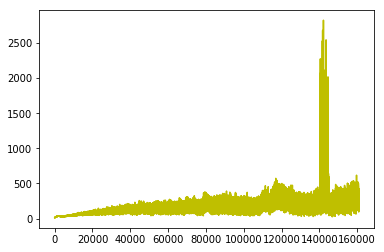

In [75]:
plot(metrics['loss'], 10)

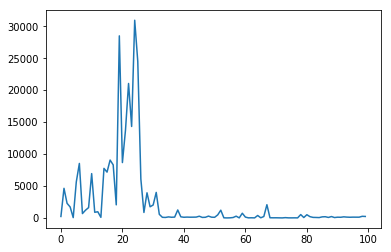

In [53]:
length = metrics['round_length'][200:300]
range_size = 1
length = [np.mean(length[i:i+range_size]) for i in range(0, len(length), range_size)]
plt.plot(length)

In [56]:
get_labels(D.batch(100))

[array([1975529.2, 1910659.8], dtype=float32),
 array([1964313.8, 1975825. ], dtype=float32),
 array([1988715.9, 1965539.8], dtype=float32),
 array([1983933.5, 1962782.8], dtype=float32),
 array([1979743.9, 1854555.5], dtype=float32),
 array([1976056.2, 1977378. ], dtype=float32),
 array([1980868.6, 1853415.5], dtype=float32),
 array([1972957.1, 1939484. ], dtype=float32),
 array([1988222.8, 1966350.9], dtype=float32),
 array([1984209.5, 1984600.9], dtype=float32),
 array([1980725.5, 1858997.2], dtype=float32),
 array([1985271.9, 1964155.9], dtype=float32),
 array([1986444. , 1974376.2], dtype=float32),
 array([1990744.4, 1961530.4], dtype=float32),
 array([1981108. , 1963468.6], dtype=float32),
 array([1949322.6, 1972167. ], dtype=float32),
 array([1991731.5, 1970472.8], dtype=float32),
 array([1991866.5, 1959029.9], dtype=float32),
 array([1983595.5, 1963789.5], dtype=float32),
 array([1988132.6, 1968003.5], dtype=float32),
 array([1975919.9, 1963347. ], dtype=float32),
 array([19796